# Lab: Decision Trees
## Fitting Classification Trees

We'll be using Scikit-Learn functions and methods to construct classification and regression trees.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

We first use classification trees  to analyze the `Carseats` data set.
In these data, `Sales` is a continuous variable, and so we begin by recoding it  as a binary variable. We use the `ifelse()` function to create a variable, called `High`, which takes on a value of `Yes` if the `Sales` variable exceeds $8$, and takes on a value of `No` otherwise.

In [25]:
Carseats = pd.read_csv('data/Carseats.csv')
Carseats['High'] = Carseats.Sales.apply(lambda x: 1 if x > 8 else 0)
# Get categorical codes of categorical columns
Carseats['ShelveLoc'] = Carseats.ShelveLoc.map({'Bad': 0, 'Medium': 1, 'Good': 2})
Carseats['Urban'] = Carseats.Urban.map({'No':0, 'Yes':1})
Carseats['US'] = Carseats.US.map({'No':0, 'Yes':1})
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,2,65,10,1,1,1
2,10.06,113,35,10,269,80,1,59,12,1,1,1
3,7.40,117,100,4,466,97,1,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


In [27]:
Carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


We now  use the `tree()` function to fit a classification tree in order to predict `High` using all variables but `Sales`.
The syntax of the `tree()` function is quite similar to that of the `lm()` function.

In [375]:
X = Carseats.drop(['Sales', 'High'], axis=1)
y = Carseats.High

In [376]:
tree = DecisionTreeClassifier().fit(X, y)
print(f'Number of terminal nodes: {tree.get_n_leaves()}')
print(f'Depth: {tree.get_depth()}')
print(f'Classification training accuracy: {tree.score(X, y)}')

Number of terminal nodes: 61
Depth: 11
Classification training accuracy: 1.0


We see that the training error rate is  $0\%$ and we completely overfit the data.

One of the most attractive properties of trees is that they can be  graphically displayed. 

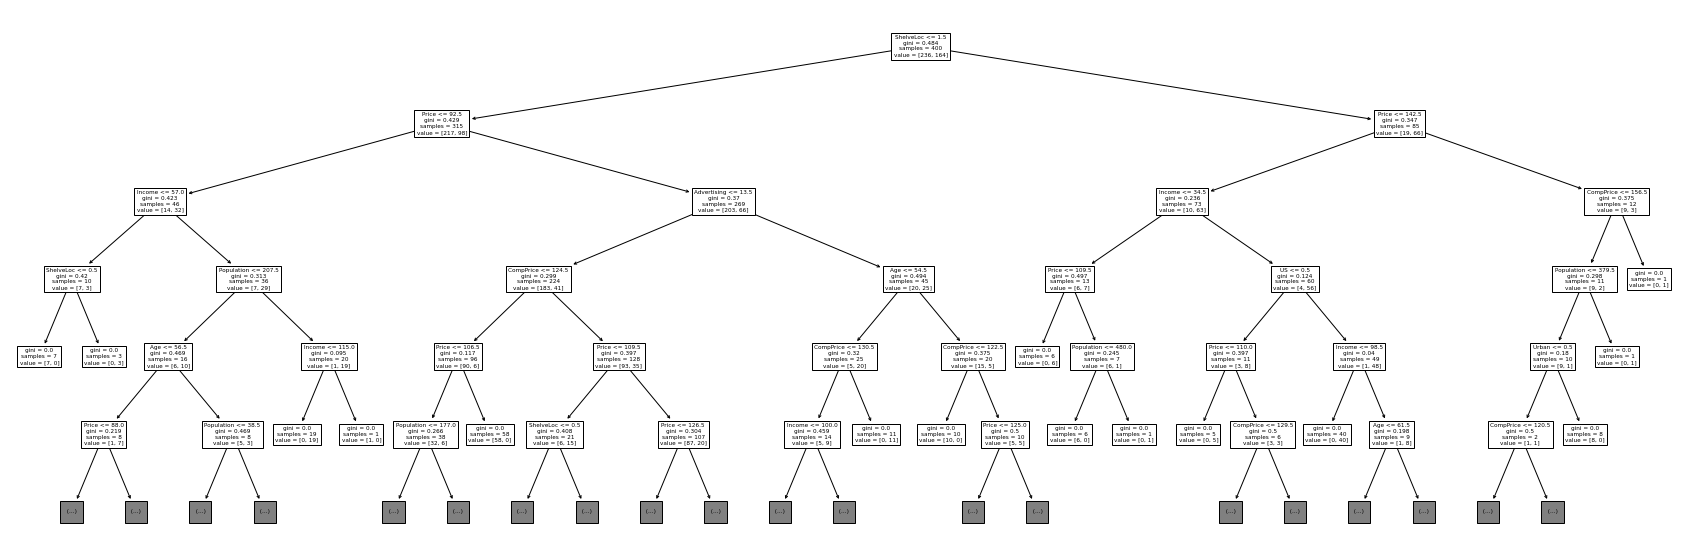

In [377]:
fig = plt.figure(figsize=(30,10))
plot_tree(tree, feature_names=tree.feature_names_in_, max_depth=5);

The most important indicator of `Sales` appears to be shelving location, since the first branch differentiates `Good` locations from `Bad` and `Medium` locations.

`Python` displays the split criterion  (e.g. `Price < 92.5`), the number of observations in  that branch, the Gini index, and the number of observations in that branch that take on values of `Yes` and `No`.

In order to properly evaluate the performance of a classification tree
on these data, we must estimate the test error rather than simply
computing the training error. We split the observations into a
training set and a test set, build the tree using the training set,
and evaluate its performance on the test data. The `predict()`
function can be used for this purpose. This approach leads to correct predictions
for around $75\,\%$ of the locations in the test data set.

In [378]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=10)

In [379]:
tree = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
pred = tree.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, pred).T, 
             index = ['No', 'Yes'], 
             columns = ['No_true', 'Yes_true'])

,No_true,Yes_true
No,95,31
Yes,18,56


In [380]:
tree.score(X_test, y_test)

0.755

In [381]:
tree.get_n_leaves()

30

Next, we consider whether pruning the tree might lead to improved  results.
We will perform cross-validation in order to  determine the optimal level of tree complexity; cost complexity pruning is used in order to select a sequence of trees for consideration.
We start by finding the alpha values correspoding to the subtrees from the original complete tree.

In [382]:
tree = DecisionTreeClassifier()
ccp_alphas = tree.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']
sizes = [DecisionTreeClassifier(ccp_alpha=alpha).fit(X_train, y_train).get_n_leaves() for alpha in ccp_alphas]

Now, we apply leave one out cross validation using the calculated alpha values to obtain the cross validation error at each alpha value.

In [9]:
from sklearn.model_selection import KFold

In [384]:
cv = KFold(len(X_train))
accuracy = np.zeros_like(ccp_alphas)
for train_index, test_index in cv.split(X_train):
    for i, alpha in enumerate(ccp_alphas):
        alpha_tree = DecisionTreeClassifier(random_state=1, ccp_alpha=alpha).fit(X_train.iloc[train_index], y_train.iloc[train_index])
        accuracy[i] += alpha_tree.score(X_train.iloc[test_index], y_train.iloc[test_index])
accuracy /= 10
alpha = ccp_alphas[accuracy.argmax()]

tree = DecisionTreeClassifier(ccp_alpha=alpha).fit(X_train, y_train)
tree.score(X_test, y_test)

0.78

In [385]:
tree.get_n_leaves()

13

The tree with 13 terminal nodes results in an accuracy of 78%.  We plot
the  accuracy as a function of both `size` and
alpha.

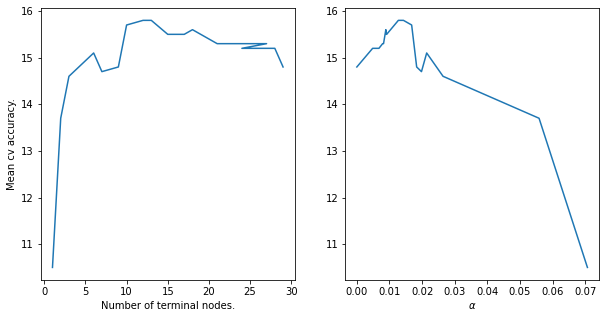

In [276]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(sizes, accuracy)
ax[0].set_xlabel('Number of terminal nodes.')
ax[0].set_ylabel('Mean cv accuracy.')
ax[1].plot(ccp_alphas, accuracy)
ax[1].set_xlabel(r'$\alpha$');

Now we visualize the best tree.

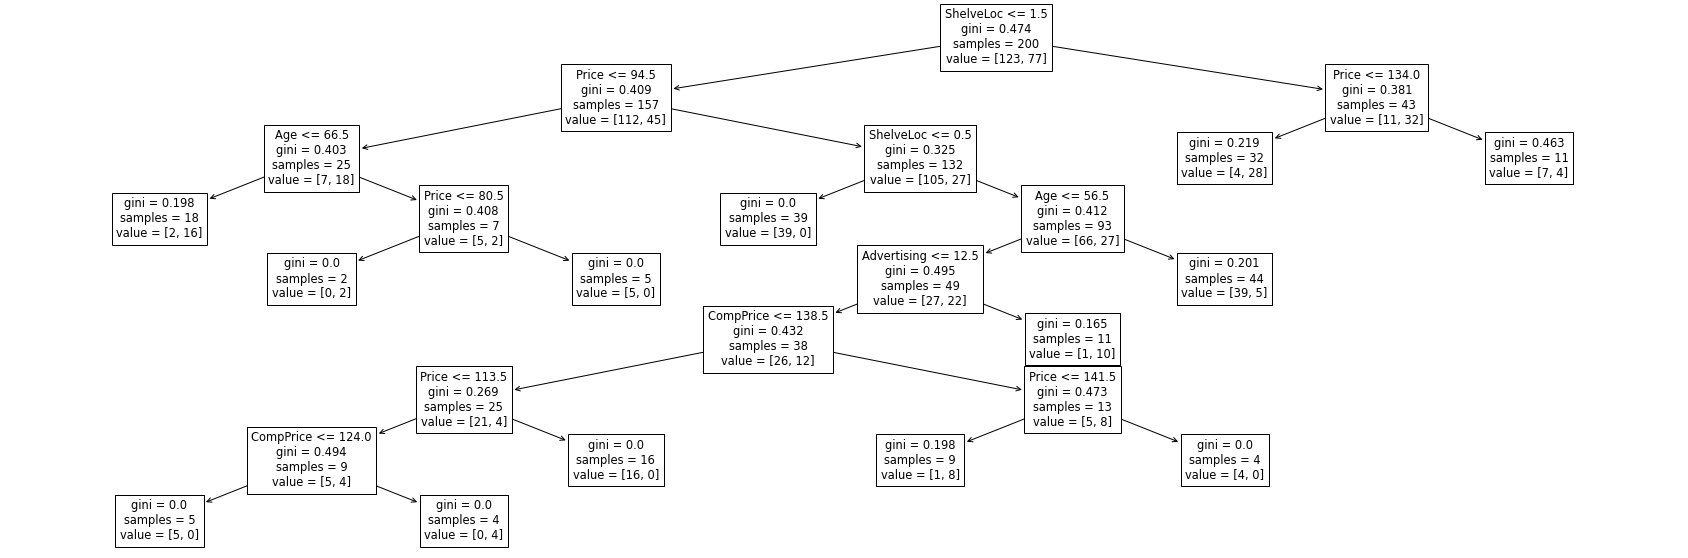

In [283]:
fig = plt.figure(figsize=(30,10))
plot_tree(tree, feature_names=tree.feature_names_in_);

How well does this pruned tree perform on the test data set? Once again, we apply the `score()` function.

In [284]:
tree.score(X_test, y_test)

0.78

Now $78\,\%$ of the test observations are correctly classified, so not only has the pruning process produced a more interpretable tree, but it has also slightly improved the classification accuracy.

If we increase the number of terminal nodes, we obtain a larger pruned tree with lower classification accuracy:

In [290]:
tree = DecisionTreeClassifier(max_leaf_nodes=14).fit(X_train, y_train)
tree.score(X_test, y_test)

0.77

## Fitting Regression Trees

Here we fit a regression tree to the `Boston`  data set. First, we create a training set, and fit the tree to the training data.

In [3]:
Boston = pd.read_csv('data/Boston.csv', index_col=0)
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [16]:
X = Boston.drop(columns='medv')
y = Boston.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.5, random_state=0)

# We'll limit the tree depth to approximate the default behaviour of the R tree function
tree = DecisionTreeRegressor(max_depth=3, random_state=1).fit(X_train, y_train)
print(f'Number of terminal nodes: {tree.get_n_leaves()}')
mean_squared_error(tree.predict(X_test), y_test)

Number of terminal nodes: 8


26.02323085009744

In [17]:
pd.Series(tree.feature_importances_, tree.feature_names_in_).sort_values(ascending=False)

lstat      0.679368
rm         0.214074
dis        0.095000
ptratio    0.011558
crim       0.000000
zn         0.000000
indus      0.000000
chas       0.000000
nox        0.000000
age        0.000000
rad        0.000000
tax        0.000000
dtype: float64

Notice that the output of `feature_importances_` indicates that only four of the variables have been used in constructing the tree. In the context of a regression tree, the error reported as the mean squared error. We now plot the tree.

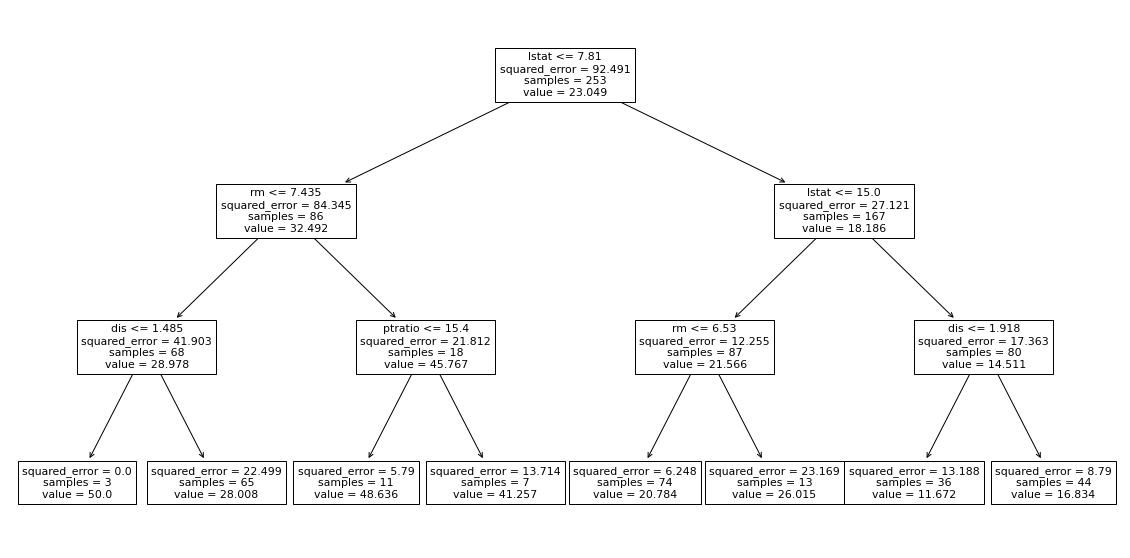

In [18]:
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=tree.feature_names_in_);

The variable `lstat` measures the percentage of individuals with lower  socioeconomic status, while the variable `rm` corresponds to the average number of rooms. The tree indicates that larger values of `rm`, or lower values of `lstat`, correspond to more expensive houses. For example, the tree predicts a median house price of $\$45{,}400$ for homes in census tracts in which `rm >= 7.553`.

It is worth noting that we could have fit a much bigger tree, by
passing not restricting the depth.

Now we apply prunning to see whether it improves performance.

In [21]:
tree = DecisionTreeRegressor(random_state=1)
ccp_alphas = tree.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']
sizes = [DecisionTreeRegressor(ccp_alpha=alpha, random_state=1).fit(X_train, y_train).get_n_leaves() for alpha in ccp_alphas]

cv = KFold(10)
r2 = np.zeros_like(ccp_alphas)
for train_index, test_index in cv.split(X_train):
    for i, alpha in enumerate(ccp_alphas):
        alpha_tree = DecisionTreeRegressor(random_state=1, ccp_alpha=alpha).fit(X_train.iloc[train_index], y_train.iloc[train_index])
        r2[i] += alpha_tree.score(X_train.iloc[test_index], y_train.iloc[test_index])
r2 /= len(X_train)
alpha = ccp_alphas[r2.argmax()]

tree = DecisionTreeRegressor(ccp_alpha=alpha).fit(X_train, y_train)
mean_squared_error(tree.predict(X_test), y_test)

25.60493910703885

In [22]:
tree.get_n_leaves()

7

In keeping with the cross-validation results, we use the unpruned tree to make predictions on the test set.

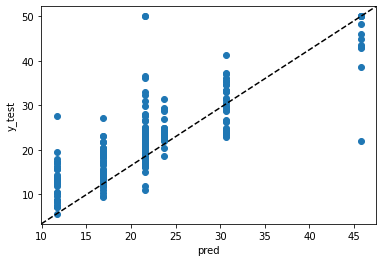

In [24]:
pred = tree.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test');

In other words, the  test set MSE associated with the regression tree is $25.60$.
The square root of the MSE is therefore around $5.06$, indicating that this model leads to test predictions that are (on average) within approximately $\$5{,}060$ of the true median home value for the census tract.


## Bagging and Random Forests



Here we apply bagging and random forests to the `Boston` data, using the `RandomForestRegressor` function in `Scikit-Learn`.
Recall that bagging is simply a special case of a random forest with
$m=p$. Therefore, the
`RandomForestRegressor()` function can be used to perform both random forests and bagging.
We perform bagging as follows:

In [25]:
bag_boston = RandomForestRegressor(max_features=1.0, random_state=1).fit(X_train, y_train)

The argument `max_features = 1.0` indicates that all predictors should be considered for each split of the tree---in other words, that bagging should be done.
How well does this bagged model perform on the test set?

16.35125252569171

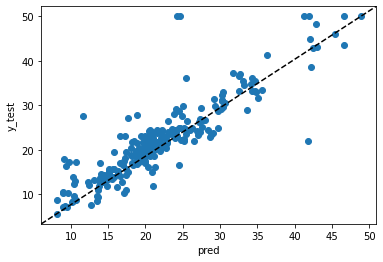

In [26]:
yhat = bag_boston.predict(X_test)
plt.scatter(yhat, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test');
mean_squared_error(yhat, y_test)

The test set MSE associated with the bagged regression tree is $16.35$, about two-thirds of that obtained using an optimally-pruned single tree.
We could change the number of trees grown by `RandomForestRegressor()` using the `n_estimators` argument:

17.498150134387355

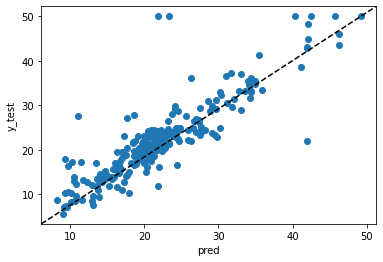

In [29]:
bag_boston = RandomForestRegressor(max_features=1.0, n_estimators=25, random_state=1).fit(X_train, y_train)

yhat = bag_boston.predict(X_test)
plt.scatter(yhat, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test');
mean_squared_error(yhat, y_test)

Growing a random forest proceeds in exactly the same way, except that we use a smaller value of the `max_features` argument. Here we use `max_features=6`. When passing an integer, we specify the number of features to use.

In [31]:
random_forest_boston = RandomForestRegressor(max_features=6, random_state=1)

random_forest_boston.fit(X_train, y_train)

yhat = random_forest_boston.predict(X_test)
mean_squared_error(y_test, yhat)

16.266221083003956

The test set MSE is $16.26$; this indicates that random forests yielded an improvement over bagging in this case.

Using the `feature_importances_` attribute, we can view the importance of each variable.

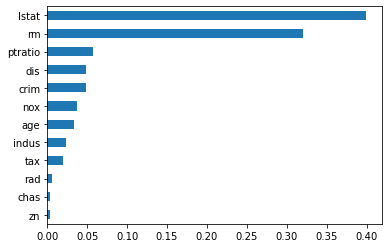

In [37]:
pd.Series(random_forest_boston.feature_importances_, random_forest_boston.feature_names_in_).sort_values(ascending=True).plot.barh();

The importance is a measure of the total decrease in node impurity that results from splits over that variable, averaged over all trees (this was plotted in Figure 8.9).

The results indicate that across all of the trees considered in the random forest, the wealth of the community (`lstat`) and the house size (`rm`) are by far the two most important variables.



## Boosting

Here we use the `GradientBoostingRegressor` function to fit boosted regression trees to the `Boston` data set. The argument `n_estimators=500` indicates that we want 500 trees, and the option `max_depth=4` limits the depth of each tree:

In [38]:
boosted_boston = GradientBoostingRegressor(n_estimators=500, 
                                           learning_rate=0.01, 
                                           max_depth=4, 
                                           random_state=1)

boosted_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=1)

Let's check out the feature importances again:

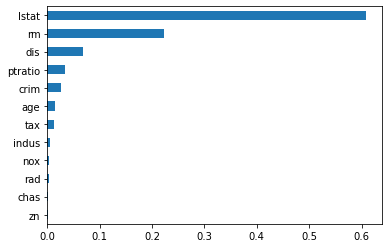

In [39]:
pd.Series(boosted_boston.feature_importances_, boosted_boston.feature_names_in_).sort_values(ascending=True).plot.barh();

We see that `lstat` and `rm` are by far the most important variables. We can also produce *partial dependence plots* for these two variables. These plots illustrate the marginal effect of the selected variables on the response after *integrating* out the other variables. In this case, as we might expect, median house prices are increasing with `rm` and decreasing with `lstat`.

In [41]:
X_train

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
233,0.57529,0.0,6.20,0,0.507,8.337,73.3,3.8384,8,307,17.4,2.47
134,0.32982,0.0,21.89,0,0.624,5.822,95.4,2.4699,4,437,21.2,15.03
34,1.15172,0.0,8.14,0,0.538,5.701,95.0,3.7872,4,307,21.0,18.35
483,5.73116,0.0,18.10,0,0.532,7.061,77.0,3.4106,24,666,20.2,7.01
45,0.12269,0.0,6.91,0,0.448,6.069,40.0,5.7209,3,233,17.9,9.55
...,...,...,...,...,...,...,...,...,...,...,...,...
324,0.28392,0.0,7.38,0,0.493,5.708,74.3,4.7211,5,287,19.6,11.74
193,0.08664,45.0,3.44,0,0.437,7.178,26.3,6.4798,5,398,15.2,2.87
118,0.15098,0.0,10.01,0,0.547,6.021,82.6,2.7474,6,432,17.8,10.30
48,0.22927,0.0,6.91,0,0.448,6.030,85.5,5.6894,3,233,17.9,18.80


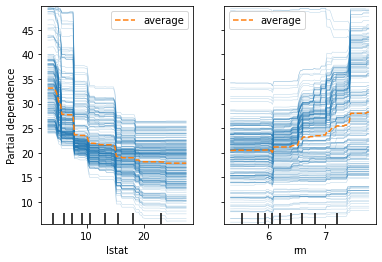

In [44]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(boosted_boston, X_train, features=['lstat', 'rm'], kind='both');

We now use the boosted model to predict `medv` on the test set:

In [45]:
yhat = boosted_boston.predict(X_test)
mean_squared_error(yhat, y_test)

17.45917952636088

In [ ]:
yhat.boost <- predict(boost.boston,
    newdata = Boston[-train, ], n.trees = 5000)
mean((yhat.boost - boston.test)^2)

The test MSE obtained is $17.46$: this is superior to the test MSE of random forests and bagging. If we want to, we can perform boosting with a different value of the shrinkage parameter $\lambda$ in (8.10). The default value is $0.001$, but this is easily modified.
Here we take $\lambda=0.2$.

In [46]:
boosted_boston2 = GradientBoostingRegressor(n_estimators=500, 
                                            learning_rate=0.2, 
                                            max_depth=4, 
                                            random_state=1)
boosted_boston2.fit(X_train, y_train)

mean_squared_error(y_test, boosted_boston2.predict(X_test))

16.951500967513155

In this case, using $\lambda=0.2$ leads to a lower test MSE than $\lambda=0.01$.




## Bayesian Additive Regression Trees


In this section  we use the `BART` package, and within it the `gbart()` function, to fit a Bayesian additive regression tree model to the `Boston` housing data set. The `gbart()` function  is
designed for quantitative outcome variables. For binary outcomes,   `lbart()`  and  `pbart()`  are available.

To run the `gbart()` function, we must first create matrices of predictors for the training and test data. We run BART with default settings.

In [ ]:
library(BART)
x <- Boston[, 1:12]
y <- Boston[, "medv"]
xtrain <- x[train, ]
ytrain <- y[train]
xtest <- x[-train, ]
ytest <- y[-train]
set.seed(1)
bartfit <- gbart(xtrain, ytrain, x.test = xtest)

Next we compute the test error.

In [ ]:
yhat.bart <- bartfit$yhat.test.mean
mean((ytest - yhat.bart)^2)

On this data set, the test error of BART is lower than the test error of random forests and boosting.

Now we can check how many times each variable appeared in the collection of trees.

In [ ]:
ord <- order(bartfit$varcount.mean, decreasing = T)
bartfit$varcount.mean[ord]